In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Add
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras import Model

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory("E:/Downloads/disease detection/kidney/dataset",    
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=64,
    image_size=(227, 227),
    shuffle=True,
    seed=42,                                                   
    validation_split=0.2,
    subset="training",                                                  
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
 )

val_ds = tf.keras.utils.image_dataset_from_directory("E:/Downloads/disease detection/kidney/dataset",
  validation_split=0.2,
  subset="validation",                                                   
  seed=42,
  image_size=(227, 227),
  batch_size=64)



Found 12446 files belonging to 4 classes.
Using 9957 files for training.
Found 12446 files belonging to 4 classes.
Using 2489 files for validation.


In [3]:
class_names = train_ds.class_names
print(class_names)

['Cyst', 'Normal', 'Stone', 'Tumor']


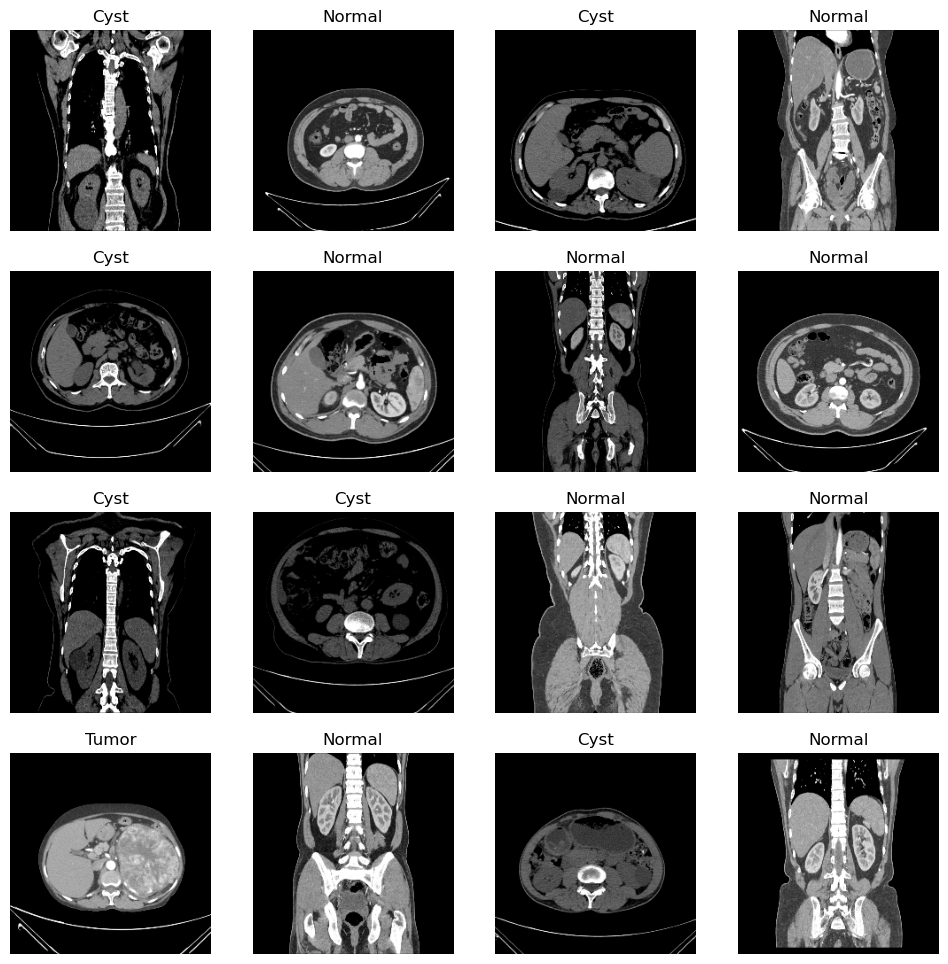

In [4]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
output_class_units = 4
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(96, (11,11),strides=(4,4), activation='relu', input_shape=(227, 227, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
  tf.keras.layers.Conv2D(256, (11,11),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(256, (7,7),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(384, (5,5),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(output_class_units, activation='softmax')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       2973952   
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

In [9]:
lr = 0.001
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) 

In [10]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
    epochs=epochs,
   )  

Epoch 1/5
128/156 [=======================>......] - ETA: 10:09 - loss: 2.3090 - accuracy: 0.6572

KeyboardInterrupt: 

In [ ]:
ModelToJSON=model.to_json()
obj=open("D:/Datasets/KidneyDiseaseDetection.json","w")
obj.write(ModelToJSON)
obj.close()
model.save_weights("D:/Datasets/KidneyDiseaseDetection.h5")

In [ ]:
loss, accuracy = model.evaluate(val_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)